**Description**: Does the Matryoshka training implementation in the [MRL
paper](https://arxiv.org/abs/2205.13147) (also in
[sentence-transformers](https://github.com/UKPLab/sentence-transformers/blob/0a32ec8445ef46b2b5d4f81af4931e293d42623f/sentence_transformers/losses/MatryoshkaLoss.py#L149))
use more memory than needed? Adding loss tensors across the loop over Matryoshka dims
causes new computation graphs and new intermediate values to get stored. We should
instead `backward` inside the loop over Matryoshka dimensions. If the batch size or
embedding dimensionality are big, and there are many Matryoshka dims, are these memory
savings considerable?

In [1]:
!pip install torchviz

In [2]:
import torch
import torchviz

In [3]:
dim = 768
W = torch.randn((dim, dim), device="cuda")


class Model(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.W = torch.nn.Parameter(W.clone())
        self.relu = torch.nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        Z = x @ self.W
        X = self.relu(Z)
        return X


class Loss(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        first, rest = X[0, :], X[1:, :]
        return (rest @ first).mean()


batch_size = 1024
x = torch.randn((batch_size, dim), device="cuda")
dims = [64, 128, 256, 512, 768]

In [4]:
model = Model().to("cuda")
loss_fn = Loss()

In [5]:
torch.cuda.memory_allocated() / 1e6

7.86432

In [6]:
X: torch.Tensor = model(x.clone())
loss = 0
for dim in dims:
    loss += loss_fn(X[:, :dim])
    print(torch.cuda.memory_allocated() / 1e6)

22.675968
22.675968
22.675968
22.675968
22.675968


In [7]:
loss.backward()

In [8]:
torch.cuda.memory_allocated() / 1e6

30.409216

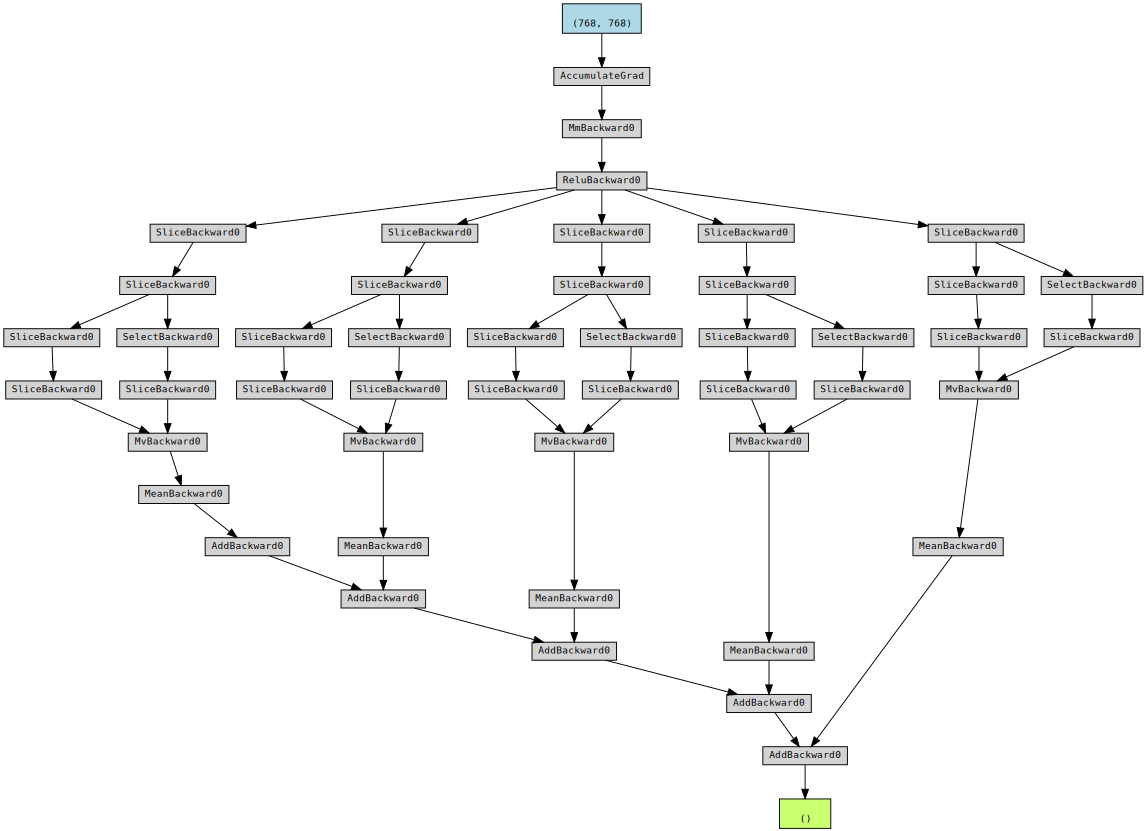

In [9]:
torchviz.make_dot(loss)

In [10]:
model2 = Model().to("cuda")
loss_fn2 = Loss()

In [11]:
torch.cuda.memory_allocated() / 1e6

32.768512

In [12]:
X: torch.Tensor = model2(x.clone())
X_detached = X.detach()
X_detached.requires_grad = True
for dim in dims:
    loss2 = loss_fn2(X_detached[:, :dim])
    print(torch.cuda.memory_allocated() / 1e6)
    loss2.backward()
    print(torch.cuda.memory_allocated() / 1e6)
X.backward(gradient=X_detached.grad)

39.06048
42.206208
42.206208
42.206208
42.206208
42.206208
42.206208
42.206208
42.206208
42.206208


In [13]:
torch.cuda.memory_allocated() / 1e6

39.06048

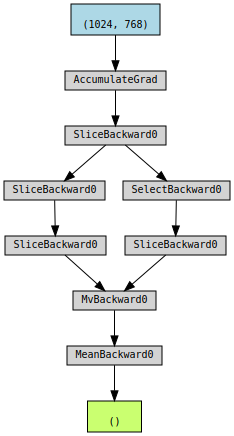

In [14]:
torchviz.make_dot(loss2)

In [15]:
assert torch.allclose(model.W.grad, model2.W.grad, atol=1e-05)